In [1]:
import os
import random
from pathlib import Path
import xml.etree.ElementTree as ET

In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34, ResNet34_Weights
from sklearn.model_selection import train_test_split

c:\Python3.9\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DATA

In [19]:
! rm -rf data
! mkdir data

In [21]:
! unzip archive.zip -d data

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
DATA_DIR = "Projects/data"
LABEL_DIR = DATA_DIR + "Projects/Road-Sign-Detection/annotations"
IMG_DIR = DATA_DIR + "Projects/Road-Sign-Detection/images"

## Loading

In [23]:
# Load image data

data = []
for path in [os.path.join(directory_path, f) for directory_path, directory_name,
        files in os.walk(LABEL_DIR) for f in files if f.endswith(".xml")]:
    dir = ET.parse(path).getroot()
    d_i = {}
    d_i['filename'] = Path(str(IMG_DIR) + '/'+ dir.find("./filename").text)
    d_i['width'] = dir.find("./size/width").text
    d_i['height'] = dir.find("./size/height").text
    d_i['class'] = dir.find("./object/name").text
    d_i['xmin'] = int(dir.find("./object/bndbox/xmin").text)
    d_i['ymin'] = int(dir.find("./object/bndbox/ymin").text)
    d_i['xmax'] = int(dir.find("./object/bndbox/xmax").text)
    d_i['ymax'] = int(dir.find("./object/bndbox/ymax").text)
    data.append(d_i)

data = pd.DataFrame(data)
labelToValue = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
data['class'] = data['class'].apply(lambda x:  labelToValue[x])

data.head()

KeyError: 'class'

## Preprocessing

In [ ]:
! rm -rf data_resized
! mkdir data_resized

In [ ]:
# Resize images and save

DATA_RESIZED_DIR = "data_resized/"
SIZE = 300

input_data = []
target_data = []


for index, d_i in data.iterrows():

    # Resize image and save
    im_i = cv2.cvtColor(cv2.imread(str(d_i['filename'])), cv2.COLOR_BGR2RGB)
    im_i_resized = cv2.resize(im_i, (int(1.49*SIZE), SIZE))
    resized_filename = DATA_RESIZED_DIR + str(d_i['filename'].parts[-1])
    cv2.imwrite(resized_filename, cv2.cvtColor(im_i_resized, cv2.COLOR_RGB2BGR))
    input_data.append(resized_filename)

    # Resize bounding box
    bb_i = np.array([d_i.values[5],d_i.values[4],d_i.values[7],d_i.values[6]])


    rows,cols,*_ = im_i.shape
    im_i_masked = np.zeros((rows, cols))
    bb_i = bb_i.astype(int)
    im_i_masked[bb_i[0]:bb_i[2], bb_i[1]:bb_i[3]] = 1.
    masked_resized = cv2.resize(im_i_masked, (int(1.49*SIZE), SIZE))

    cols, rows = np.nonzero(masked_resized)
    if len(cols)==0:
        resized_bb  = np.zeros(4, dtype=np.float32)
    else:
      top_row = np.min(rows)
      left_col = np.min(cols)
      bottom_row = np.max(rows)
      right_col = np.max(cols)

      resized_bb = np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

    target_data.append(resized_bb)

data['input'] = input_data
data['target'] = target_data

data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,input,target
0,data/images/road416.png,300,400,0,67,98,148,180,data_resized/road416.png,"[73.0, 99.0, 134.0, 220.0]"
1,data/images/road867.png,300,400,0,73,125,124,176,data_resized/road867.png,"[93.0, 108.0, 131.0, 185.0]"
2,data/images/road773.png,300,400,0,184,188,204,208,data_resized/road773.png,"[141.0, 273.0, 155.0, 304.0]"
3,data/images/road14.png,267,400,3,153,202,221,347,data_resized/road14.png,"[151.0, 255.0, 260.0, 370.0]"
4,data/images/road371.png,300,400,0,67,219,152,301,data_resized/road371.png,"[164.0, 99.0, 225.0, 226.0]"


In [ ]:
X = data[['input', "class"]]
y = data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=34)

In [ ]:
! rm -rf data

## Create Dataset

In [ ]:
class DetectionDataset(Dataset):
    def __init__(self, images, boxes, aug=False):
        self.images = images.values
        self.boxes = boxes.values
        self.augmentation = aug

    def normalize(self, im):
        imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
        return (im - imagenet_stats[0])/imagenet_stats[1]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        im_i = self.images[idx]
        bb_i = self.boxes[idx]

        im_i = cv2.imread(str(im_i)).astype(np.float32)
        im_i = cv2.cvtColor(im_i, cv2.COLOR_BGR2RGB)/255


        rows,cols,*_ = im_i.shape
        im_i_masked = np.zeros((rows, cols))
        bb_i_masked = bb_i.astype(int)
        im_i_masked[bb_i_masked[0]:bb_i_masked[2], bb_i_masked[1]:bb_i_masked[3]] = 1.


        if self.augmentation:
          deg = (np.random.random()-.50)*20
          r,c,*_ = im_i.shape
          im_i = cv2.warpAffine(im_i,cv2.getRotationMatrix2D((c/2,r/2),deg,1),(c,r), borderMode=cv2.BORDER_REFLECT, flags=cv2.WARP_FILL_OUTLIERS+cv2.INTER_AREA)


          r,c,*_ = im_i_masked.shape
          im_i_masked = cv2.warpAffine(im_i_masked, cv2.getRotationMatrix2D((c/2,r/2),deg,1),(c,r), borderMode=cv2.BORDER_CONSTANT)

          if np.random.random() > 0.5:
              im_i = np.fliplr(im_i).copy()
              im_i_masked = np.fliplr(im_i_masked).copy()

          r, c,*_ = im_i.shape
          r_pix=8
          c_pix = round(r_pix*c/r)
          rand_r = random.uniform(0, 1)
          rand_c = random.uniform(0, 1)
          start_r = np.floor(2*rand_r*r_pix).astype(int)
          start_c = np.floor(2*rand_c*c_pix).astype(int)
          im_i = im_i[start_r:start_r+r-2*r_pix, start_c:start_c+ c-2*c_pix]
          im_i_masked = im_i_masked[start_r:start_r+r-2*r_pix, start_c:start_c+ c-2*c_pix]


        else:
          r, c,*_ = im_i.shape
          r_pix = 8
          c_pix = round(r_pix*c/r)
          im_i = im_i[r_pix:r_pix+r-2*r_pix, c_pix:c_pix+c-2*c_pix]

          r, c,*_ = im_i_masked.shape
          r_pix = 8
          c_pix = round(r_pix*c/r)
          im_i_masked = im_i_masked[r_pix:r_pix+r-2*r_pix, c_pix:c_pix+c-2*c_pix]


        cols, rows = np.nonzero(im_i_masked)
        if len(cols)==0:
            bb_i  = np.zeros(4, dtype=np.float32)
        else:
          top_row = np.min(rows)
          left_col = np.min(cols)
          bottom_row = np.max(rows)
          right_col = np.max(cols)

          bb_i = np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


        im_i = self.normalize(im_i)
        im_i = np.rollaxis(im_i, 2)

        return im_i, bb_i

## Setup Dataloader

In [ ]:
BATCH_SIZE = 64

train_dataset = DetectionDataset(X_train['input'] ,y_train, aug=True)
val_dataset = DetectionDataset(X_val['input'],y_val)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# MODEL

In [ ]:
class BB(nn.Module):
    def __init__(self):
        super(BB, self).__init__()
        resnet = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.bb(x)

In [ ]:
model = BB().to(device)
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.002)

## Dataloader

In [ ]:
EPOCHS = 100

min_val_loss = float("inf")
for e in range(EPOCHS):
        print("Epoch ", e)

        model.train()
        train_loss = 0.0
        for x_i, y_i in train_dataloader:
            x_i, y_i = x_i.to(device).float(), y_i.to(device).float()

            y_p = model(x_i)
            loss = F.l1_loss(y_p, y_i, reduction="none").sum(1)
            loss = loss.sum()
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = train_loss/(len(train_dataloader)*BATCH_SIZE)
        print("Train loss: ", train_loss)

        model.eval()
        val_loss = 0.0
        for x_i, y_i in val_dataloader:
            x_i, y_i = x_i.to(device).float(), y_i.to(device).float()

            y_p = model(x_i)
            loss = F.l1_loss(y_p, y_i, reduction="none").sum(1)
            loss = loss.sum()
            val_loss += loss.item()

        val_loss = val_loss/(len(val_dataloader)*BATCH_SIZE)
        print("Val loss: ", val_loss)

        if val_loss<min_val_loss:
          min_val_loss = val_loss
          print("SAVING MODEL - BEST VALIDATION LOSS SO FAR")
          torch.save(model.state_dict(), "model")


Epoch  0
Train loss:  656.6120971679687
Val loss:  640.7421035766602
SAVING MODEL - BEST VALIDATION LOSS SO FAR
Epoch  1
Train loss:  664.3339202880859
Val loss:  1270.6382080078124
Epoch  2
Train loss:  657.4091827392579
Val loss:  1077.9486877441407
Epoch  3
Train loss:  645.5804565429687
Val loss:  2396.3249389648436
Epoch  4
Train loss:  642.5480102539062
Val loss:  533.9430526733398
SAVING MODEL - BEST VALIDATION LOSS SO FAR
Epoch  5
Train loss:  632.377978515625
Val loss:  549.0982666015625
Epoch  6
Train loss:  615.639892578125
Val loss:  499.8630035400391
SAVING MODEL - BEST VALIDATION LOSS SO FAR
Epoch  7
Train loss:  594.7148620605469
Val loss:  529.5791015625
Epoch  8
Train loss:  571.3529174804687
Val loss:  454.20228881835936
SAVING MODEL - BEST VALIDATION LOSS SO FAR
Epoch  9
Train loss:  545.3796264648438
Val loss:  713.8839050292969
Epoch  10
Train loss:  513.7397827148437
Val loss:  425.89979400634763
SAVING MODEL - BEST VALIDATION LOSS SO FAR
Epoch  11
Train loss:  47

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Bounding Box Coordinates: [[107.38527 214.7553  159.97148 300.77588]]


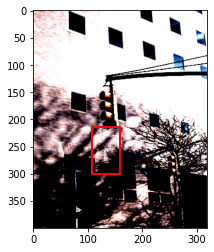

In [17]:
import matplotlib.pyplot as plt


class BB(nn.Module):
    def __init__(self):
        super(BB, self).__init__()
        resnet = resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        return self.bb(x)

# Create an instance of the model
model = BB()

# Load the saved model state_dict
model.load_state_dict(torch.load("Projects/detection_model_weights"))

# Set the model to evaluation mode
model.eval()

image_path = "Projects/Road-Sign-Detection/images/road7.png"
im_i = cv2.imread(image_path).astype(np.float32)
im_i = cv2.cvtColor(im_i, cv2.COLOR_BGR2RGB) / 255
im_i = (im_i - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
im_i = np.rollaxis(im_i, 2)
im_i_tensor = torch.from_numpy(im_i).unsqueeze(0).float()

# Make predictions
with torch.no_grad():
    output = model(im_i_tensor)

print("Predicted Bounding Box Coordinates:", output.numpy())

# Convert the output tensor to numpy array
predicted_bb = output.numpy()[0]

# Convert im_i_tensor back to NumPy array and squeeze
im_i_np = im_i_tensor.squeeze().numpy()

# Plot the image with the bounding box
plt.imshow(im_i_np.transpose(1, 2, 0))  # Transpose the axes
plt.gca().add_patch(plt.Rectangle((predicted_bb[0], predicted_bb[1]),
                                   predicted_bb[2] - predicted_bb[0],
                                   predicted_bb[3] - predicted_bb[1],
                                   fill=False, edgecolor='r', linewidth=2))
plt.show()